# pg_server_cache 
Analyzing the PG Server cache. 
## Cells
- Configuration - a connection string
- Prereq - verify the extension pg_buffercache installed (assumes pg_stat_statements already installed)
- Total buffer size - total size of the buffer cache
- Buffer cache by DB - Show how many buffers each DB uses, using the view pg_buffercache. 

## Configuration
Open a connection to the DB. Use a Connection String stored in a .cfg file

In [1]:
import sqlalchemy
import psycopg2
import pandas as pd
import configparser
import matplotlib.pyplot as plt 

# Read from the Config file
config = configparser.ConfigParser() 
config.read_file(open(r'../ipynb.cfg'))

con_str = config.get('con_str', 'PG_AIRBASES') 

engine = sqlalchemy.create_engine(con_str)

# print("Connecting with engine " + str(engine))
try:
    connection = engine.connect()
except (Exception, sqlalchemy.exc.SQLAlchemyError) as error:
    print("Error while connecting to PostgreSQL database:", error)



## Pre-Req
Check whether the extension exists
TODO: The cell below doesn't really work. The query returns "false" but the code ignores it. Maybe it returns the string "false" rather than a bit

In [2]:

from sqlalchemy import create_engine
from sqlalchemy.exc import SQLAlchemyError

sql_command = """
SELECT CASE WHEN COUNT(*) > 0 THEN B'1'::BIT(1) ELSE B'0'::BIT(1) END AS extension_exists
FROM pg_extension
WHERE extname = 'pg_buffercache';
"""
df = pd.read_sql_query(sql_command, connection)

try:
    # Execute the SQL command
   
    result = connection.execute(sql_command).fetchone()

    # print (type(result[0]))
        # Check the result
    if result[0] == '0':
        raise ValueError("Error: The extension pg_buffercache doesn't exist ")
    else: 
        print ("The Extension pg_buffercache exists")
except (SQLAlchemyError, ValueError) as e:
    # Handle any errors or raised exceptions
    raise e


The Extension pg_buffercache exists


## Total Buffer Size
The ```pg_buffercache``` module provides a means for examining what's happening in the shared buffer cache in real time.
The module provides a C function pg_buffercache_pages that returns a set of records, plus a view pg_buffercache that wraps the function for convenient use. https://www.postgresql.org/docs/current/pgbuffercache.html. 
The total size of the buffer cache should be equal to the setting  ```shared_buffers``` ( Show shared_buffers)

In [3]:
qry_total_buffer_size = """
SELECT 
	count(*) as count_buffers, 
	count(*) * 8 as total_buffers_size_kb
FROM pg_buffercache 
"""

df = pd.read_sql_query(qry_total_buffer_size, connection)
df

,count_buffers,total_buffers_size_kb
0,243066,1944528


## Buffers used by Each DB
Shows how many buffers each db uses (as a number as in KB). It also shows the percentage of each DB buffers usage from total.
Resources: https://tomasz-gintowt.medium.com/postgresql-extensions-pg-buffercache-b38b0dc08000 

In [4]:

qry_total_buffer_size = """
WITH TotalBufferCount AS (
    SELECT count(*) AS total_buffers
    FROM pg_buffercache
)

SELECT 
    CASE 
        WHEN c.reldatabase IS NULL THEN ''
        WHEN c.reldatabase = 0 THEN ''
        ELSE d.datname
    END AS database,
    count(*) AS cached_blocks,
    round(count(*) * 100.0 / tb.total_buffers, 5) AS percent_of_total
FROM pg_buffercache AS c
LEFT JOIN pg_database AS d
    ON c.reldatabase = d.oid
CROSS JOIN TotalBufferCount AS tb
GROUP BY d.datname, c.reldatabase, tb.total_buffers
ORDER BY d.datname, c.reldatabase;
"""

df = pd.read_sql_query(qry_total_buffer_size, connection)
df

,database,cached_blocks,percent_of_total
0,airbases,14269,5.87042
1,airbases-demo,5855,2.40881
2,airbases-qa,76,0.03127
3,bh,422,0.17362
4,bh2,76,0.03127
5,books,82,0.03374
6,demo,77,0.03168
7,grafana_demo,82,0.03374
8,metis-qa-airbases,78,0.03209
9,platform-v2,221290,91.04112


### Buffers used by each DB - Pie Chart

<Figure size 1000x600 with 0 Axes>

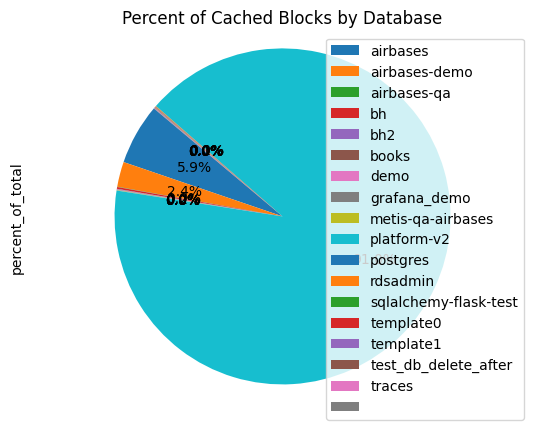

In [5]:
plt.figure(figsize=(10, 6))
df.plot.pie(y="percent_of_total", autopct="%1.1f%%", startangle=140, labels=[None] * len(df))
plt.axis("equal")  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.title("Percent of Cached Blocks by Database")
plt.legend(labels=df["database"], loc="upper right")
plt.show()

## Tables (in a single DB) Cache Hit Ratio.
Postgres caches recent queries in memory called the shared buffer cache (shared_buffers in postgresql.conf). The pg_statio_user_tables has as rows representing various stats on each of the (user) tables. The two columns of interest we’ll be looking at are:

* pg_statio_user_tables.heap_blks_read — Number of disk blocks read from a table (ie. missed cache)
* pg_statio_user_tables.heap_blks_hits — Number of buffer hits from this table (ie. cache hit)


In [6]:
query_ccnnections_metrics = """
SELECT 
  schemaname, 
  pg_class.relname, 
  ROUND(
    CASE 
      WHEN heap_blks_hit + heap_blks_read = 0 
      THEN 0 
      ELSE heap_blks_hit::decimal / (heap_blks_hit + heap_blks_read) 
    END, 
    3
  ) as cache_hit_ratio
FROM 
  pg_statio_user_tables 
  JOIN pg_class ON pg_statio_user_tables.relid = pg_class.oid 
  JOIN pg_namespace ON pg_namespace.oid = pg_class.relnamespace;
"""

df = pd.read_sql_query(query_ccnnections_metrics, connection)
df

,schemaname,relname,cache_hit_ratio
0,metis,pg_stat_database_snapshots,0.863
1,metis,queries,0.996
2,metis,pg_stat_tables_activity_snapshots,0.808
3,cron,job,0.579
4,logs,postgres_logs,0.000
5,public,sales_table,0.991
6,metis,postgres_server_settings,0.000
7,metis_qa,test_high_indexes_num,0.000
8,postgres_air,aircraft,0.000
9,postgres_air,airport,0.773
